In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [3]:
%cd /content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs
os.listdir('.')[:4]

/content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs


['SubSampled_put_back_item_3_1613086200_1.mp4.npz',
 'SubSampled_put_back_item_4_1613086253_1.mp4.npz',
 'SubSampled_put_back_item_5_1613086310_1.mp4.npz',
 'SubSampled_put_back_item_1_1613086093_1.mp4.npz']

In [4]:
DATASET = '/content/drive/My Drive/iot_dataset/Preprocess_Videos/outputs'
os.listdir(DATASET)[:4]

['SubSampled_put_back_item_3_1613086200_1.mp4.npz',
 'SubSampled_put_back_item_4_1613086253_1.mp4.npz',
 'SubSampled_put_back_item_5_1613086310_1.mp4.npz',
 'SubSampled_put_back_item_1_1613086093_1.mp4.npz']

In [5]:
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.npz'))]
videos = [r.split('/')[7] for r in result]

In [6]:
def extract_trajectories(keypoints):
  trajectory = []
  for _,k in keypoints:
    if len(k) !=0: #removes data where nothing is happening
      three_d_point = k[0,[0,1,3],:] #understand this code!!! look it up in the documentation
      trajectory.append(three_d_point)

  return trajectory

In [7]:
data = []
result_num = []
for video in videos:
    data = np.load(video,allow_pickle = True)
    trajectory = extract_trajectories(data["keypoints"])
    result_num.append(trajectory)

In [8]:
len(result_num)

218

In [9]:
np.stack(result_num[1]).shape

(83, 3, 17)

In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'
os.listdir(DATASET)
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]  # extract all the mp4 file.
labels = [r.split('/')[7] for r in result]
labels.pop(114)
labels.pop(169)

'take_out_item'

In [ ]:
np.stack(result_num[1]).shape[0]

83

In [ ]:
# find the largest num of frames of each video
ll = float('-inf')
l = []
for i in range(len(result_num)):
    m = np.stack(result_num[i]).shape[0]
    l.append(m)
ll = max(l)

In [ ]:
ll

100

In [ ]:
# make sure all videos have the same length
for i in range(len(result_num)):
    for m in range(len(result_num[i]),ll+1):
        result_num[i].append(np.zeros((3,17)))

In [ ]:
np.stack(result_num[1]).shape

(101, 3, 17)

In [ ]:
result_num = np.array(result_num)

In [ ]:
X_reshape = result_num.reshape((218,101*17*3))

In [ ]:
X_reshape.shape

(218, 5151)

## Step 1: Whitening transformtion
https://en.wikipedia.org/wiki/Whitening_transformation   <br>
A whitening transformation or sphering transformation is a linear transformation that transforms a vector of random variables with a known covariance matrix into a set of new variables whose covariance is the identity matrix, meaning that they are uncorrelated and each have variance 1.

In [ ]:
def whiten(X, method='zca'):
    """
    Whitens the input matrix X using specified whitening method.
    Inputs:
        X:      Input data matrix with data examples along the first dimension
        method: Whitening method. Must be one of 'zca', 'zca_cor', 'pca',
                'pca_cor', or 'cholesky'.
    """
    X = X.reshape((-1, np.prod(X.shape[1:])))
    X_centered = X - np.mean(X, axis=0)
    Sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    W = None
    
    if method in ['zca', 'pca', 'cholesky']:
        U, Lambda, _ = np.linalg.svd(Sigma) # SVD,U is eigenvector, Lambda is eigenvalue
        if method == 'zca':
            W = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T))
        elif method =='pca':
            W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T)  # PCA: eigenvalue * (1/np.sqrt(lambda)) * eigenvalue.T
            # W = U.T
        elif method == 'cholesky':
            W = np.linalg.cholesky(np.dot(U, np.dot(np.diag(1.0 / (Lambda + 1e-5)), U.T))).T
    elif method in ['zca_cor', 'pca_cor']:
        V_sqrt = np.diag(np.std(X, axis=0))
        P = np.dot(np.dot(np.linalg.inv(V_sqrt), Sigma), np.linalg.inv(V_sqrt))
        G, Theta, _ = np.linalg.svd(P)
        if method == 'zca_cor':
            W = np.dot(np.dot(G, np.dot(np.diag(1.0 / np.sqrt(Theta + 1e-5)), G.T)), np.linalg.inv(V_sqrt))
        elif method == 'pca_cor':
            W = np.dot(np.dot(np.diag(1.0/np.sqrt(Theta + 1e-5)), G.T), np.linalg.inv(V_sqrt))
    else:
        raise Exception('Whitening method not found.')

    return (np.dot(X_centered, W.T),X_centered)

In [ ]:
X_reshape_whiten_pca, X_centered_data = whiten(X_reshape, method='pca')
X_reshape_whiten_zca, X_centered_data = whiten(X_reshape, method='zca')
X_reshape_whiten_cholesky, X_centered_data = whiten(X_reshape, method='cholesky')

In [ ]:
print('shape of centered data:' +str(X_centered_data.shape))
print('shape after pca:' +str(X_reshape_whiten_pca.shape))
print('shape after zca:' +str(X_reshape_whiten_zca.shape))
print('shape after cholesky:' +str(X_reshape_whiten_cholesky.shape))

shape of centered data:(218, 5151)
shape after pca:(218, 5151)
shape after zca:(218, 5151)
shape after cholesky:(218, 5151)


In [ ]:
X_centered_data.shape

(218, 5151)

In [ ]:
X_whiten_pca = pd.DataFrame(X_reshape_whiten_pca)
X_whiten_zca = pd.DataFrame(X_reshape_whiten_zca)
X_whiten_cholesky = pd.DataFrame(X_reshape_whiten_cholesky)
X_centered = pd.DataFrame(X_centered_data)

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/iot/feature selection/

/content/drive/My Drive/Colab Notebooks/iot/feature selection


In [ ]:
X_whiten_pca.to_csv('X_whiten_pca.csv')
X_whiten_zca.to_csv('X_whiten_zca.csv')
X_whiten_cholesky.to_csv('X_whiten_cholesky.csv')

In [ ]:
X_centered.to_csv('X_centered.csv')

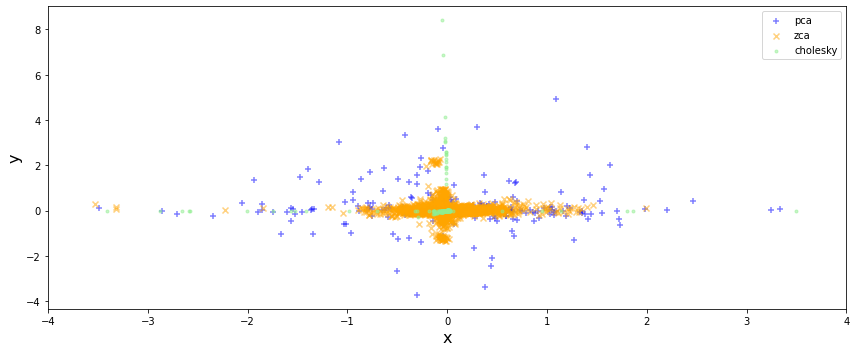

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.xlim([-4,4])
plt.scatter(X_reshape_whiten_pca[0,:], X_reshape_whiten_pca[1,:], marker = '+', label='pca', alpha=0.5, color = 'blue')
plt.scatter(X_reshape_whiten_zca[0,:], X_reshape_whiten_zca[1,:], marker = 'x', label='zca', alpha=0.5, color = 'orange')
plt.scatter(X_reshape_whiten_cholesky[0,:], X_reshape_whiten_cholesky[1,:], marker = '.', label='cholesky', alpha=0.5, color = 'lightgreen')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig('whiten_3.png', dpi=300)

- Apply PCA/ZCA reduce the number of samples, make sure the number of samples is less than the number of variables. In that case, we could use SAVE method or some other methods. And whitening can help to do PCA/ZCA.
- Here from the plot, X after ZCA has a good whitening feature.

In [ ]:
X_save = X_whiten_zca.iloc[:,0:218]

In [ ]:
X_save.shape

(218, 218)

#SAVE Algorithm

Feature selection:
http://www.stat.umn.edu/RegGraph/RecentDev/save.pdf
- SAVE: Sliced average variance estimation, dimension reduction methods that try to reduce the dimension of X without losing any information on Y|X, and without requiring a model for Y|X.
- Two conditions:<br>
- 1) require condtions on the marginal distribution of X, and requires that E(Z|beta*Z) be linear in beta*Z, and it will be satisfied if it is satisfied with each subpopulation determined by the value of Y. It holds when Z is normally distributed and can also checked from the cells of scatterplot matrix.
- 2) require a constant covariance condition: Var(Z|beta*Z) must be constant, where beta is still a basis matrix for Sy|z.


In [ ]:
!pip install sliced

     |████████████████████████████████| 43 kB 1.2 MB/s 


In [ ]:
from sliced import SlicedAverageVarianceEstimation

In [ ]:
labels = np.array(labels)

In [ ]:
labels.shape

(218,)

In [ ]:
save = SlicedAverageVarianceEstimation(n_slices=10)

In [ ]:
X_saved = save.fit_transform(X_save, labels)

/usr/local/lib/python3.7/dist-packages/sliced/base.py:93: UserWarning: n_slices greater than the number of unique y values. Setting n_slices equal to 5.
  "Setting n_slices equal to {0}.".format(counts.shape[0]))


In [ ]:
X_saved.shape

(218, 93)

## Logistic regression 

In [ ]:
kfolds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [ ]:
for train_index, test_index in kfolds.split(X_reshape):
    X_train, X_test = X_reshape[train_index], X_reshape[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    print("X_train shape:" + str(X_train.shape),"X_test shape" + str(X_test.shape))
    print("y_train shape:" + str(y_train.shape),"y_test shape" + str(y_test.shape))

X_train shape:(174, 5151) X_test shape(44, 5151)
y_train shape:(174,) y_test shape(44,)
X_train shape:(174, 5151) X_test shape(44, 5151)
y_train shape:(174,) y_test shape(44,)
X_train shape:(174, 5151) X_test shape(44, 5151)
y_train shape:(174,) y_test shape(44,)
X_train shape:(175, 5151) X_test shape(43, 5151)
y_train shape:(175,) y_test shape(43,)
X_train shape:(175, 5151) X_test shape(43, 5151)
y_train shape:(175,) y_test shape(43,)


In [ ]:
for train_index, test_index in kfolds.split(X_saved):
    X_train, X_test = X_saved[train_index], X_saved[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    print("X_train shape:" + str(X_train.shape),"X_test shape" + str(X_test.shape))
    print("y_train shape:" + str(y_train.shape),"y_test shape" + str(y_test.shape))

X_train shape:(174, 93) X_test shape(44, 93)
y_train shape:(174,) y_test shape(44,)
X_train shape:(174, 93) X_test shape(44, 93)
y_train shape:(174,) y_test shape(44,)
X_train shape:(174, 93) X_test shape(44, 93)
y_train shape:(174,) y_test shape(44,)
X_train shape:(175, 93) X_test shape(43, 93)
y_train shape:(175,) y_test shape(43,)
X_train shape:(175, 93) X_test shape(43, 93)
y_train shape:(175,) y_test shape(43,)


In [ ]:
param_grid = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [ ]:
from collections import defaultdict
accuracy_baseline = defaultdict(dict)
for i in param_grid:
  # baseline
  # if we don't reduce dimension
  for train_index,test_index in kfolds.split(X_reshape):
    X_train, X_test = X_reshape[train_index], X_reshape[test_index]
    y_train, y_test = labels[train_index], labels[test_index] 
    log_baseline = LogisticRegression(C = i)
    log_baseline.fit(X_train,y_train)
    ypred_baseline = log_baseline.predict(X_test)
    acc_base = accuracy_score(ypred_baseline,y_test)

    accuracy_baseline[i] = acc_base
    print('accuracy of baseline is:' + str(acc_base), 'param = ' + str(i))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.6136363636363636 param = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5454545454545454 param = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.4186046511627907 param = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5116279069767442 param = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5 param = 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5909090909090909 param = 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.46511627906976744 param = 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5116279069767442 param = 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.6136363636363636 param = 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.4418604651162791 param = 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.4883720930232558 param = 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5909090909090909 param = 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5454545454545454 param = 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.4418604651162791 param = 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5116279069767442 param = 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5 param = 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5909090909090909 param = 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5681818181818182 param = 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.4418604651162791 param = 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5348837209302325 param = 10


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.6136363636363636 param = 100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.4418604651162791 param = 100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5348837209302325 param = 100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5227272727272727 param = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.6136363636363636 param = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.5454545454545454 param = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy of baseline is:0.4418604651162791 param = 1000
accuracy of baseline is:0.4883720930232558 param = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
accuracy_baseline

defaultdict(dict,
            {0.001: 0.5116279069767442,
             0.01: 0.5116279069767442,
             0.1: 0.4883720930232558,
             1: 0.5116279069767442,
             10: 0.5348837209302325,
             100: 0.5348837209302325,
             1000: 0.4883720930232558})

In [ ]:
accuracy_save = defaultdict(dict)
for i in param_grid:
  # baseline
  # if we don't reduce dimension
  for train_index,test_index in kfolds.split(X_reshape_whiten_zca):
    X_train, X_test = X_reshape_whiten_zca[train_index], X_reshape_whiten_zca[test_index]
    y_train, y_test = labels[train_index], labels[test_index] 
    log_save = LogisticRegression(C = i)
    log_baseline.fit(X_train,y_train)
    ypred_save = log_baseline.predict(X_test)
    acc_save = accuracy_score(ypred_save,y_test)

    accuracy_save[i] = acc_save

In [ ]:
accuracy_save

defaultdict(dict,
            {0.001: 0.3953488372093023,
             0.01: 0.3953488372093023,
             0.1: 0.3953488372093023,
             1: 0.3953488372093023,
             10: 0.3953488372093023,
             100: 0.3953488372093023,
             1000: 0.3953488372093023})

In [ ]:
directions = np.dot(covm_sqrt_inv, evecs)  #each column is a eigen-vector

    if self.n_directions == "auto":
      n_directions = np.argmax(np.abs(np.diff(evals))) + 1
    self.n_directions_ = n_directions

    #normalize dirctions
    directions = normalize(
        directions[:, :self.n_directions_], norm="l2", axis=0
    )
    self.directions_ = directions.T

    self.eigenvalues_ = evals[:self.n_directions_]